# FWI of the 2D acoustic Marmousi 2 model

## Setup

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage

from pyseis.wave_equations import acoustic_isotropic
from pyseis.wavelets.acoustic import Acoustic2D
from pyseis import inversion
import plotting

MARMOUSI_PATH = 'Marmousi2_elastic.npz'

## Load and plot marmousi 

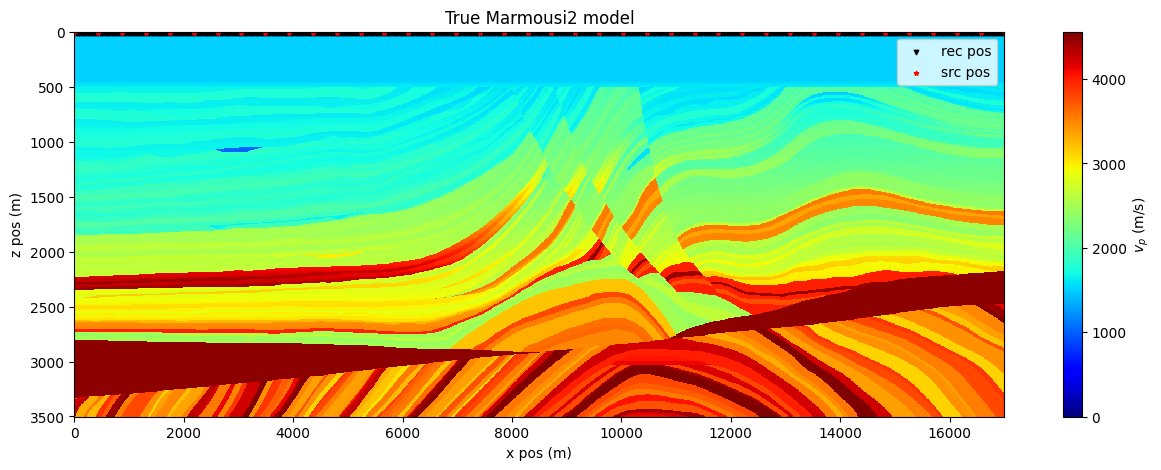

In [3]:
# load marmousi model
marm_npz = np.load(MARMOUSI_PATH)
true_model = marm_npz['model'][0] # window out p-wave velocity
model_sampling = tuple(marm_npz['model_sampling'])

# create source and receiver geometry
n_rec = true_model.shape[0]//2
x_rec = np.linspace(0.0,model_sampling[0]*true_model.shape[0],num=n_rec)
z_rec = 10.0 * np.ones_like(x_rec) 
recs = np.array([x_rec, z_rec]).T

n_src = 40
x_src = np.linspace(0.0,model_sampling[0]*true_model.shape[0],num=n_src)
z_src = 10.0 * np.ones_like(x_src) 
srcs = np.array([x_src, z_src]).T

plotting.plot_model(true_model,
           title='True Marmousi2 model', 
           cbar=True,
           src_locations=srcs,
           rec_locations=recs)

## Initialize acoustic wave equation solver

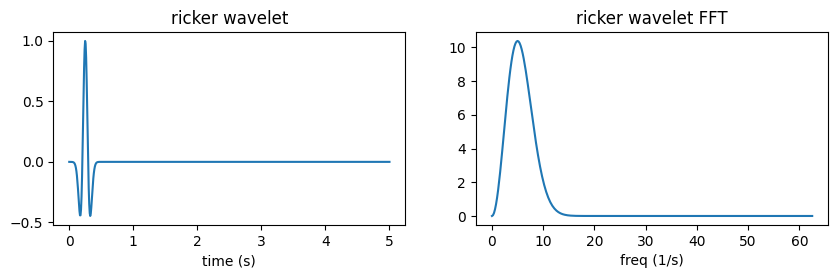

In [4]:
# make a Ricker wavelet
n_t = 626
d_t = 0.008
dom_freq = 5.0
delay = 0.25
ricker = Acoustic2D.AcousticIsotropicRicker2D(n_t, d_t, dom_freq, delay).arr

plot_wavelet(ricker,d_t,title='ricker wavelet')

In [5]:
# make 2d acoustic wave equation solver
acoustic_2d = acoustic_isotropic.AcousticIsotropic2D(
  model=true_model,
  model_sampling=model_sampling,
  model_padding=(50, 50),
  wavelet=ricker,
  d_t=d_t,
  src_locations=srcs,
  rec_locations=recs,
  gpus=[0,1,2,3])

## Make observed data

CPU times: user 1min 6s, sys: 27.8 s, total: 1min 34s
Wall time: 16.9 s


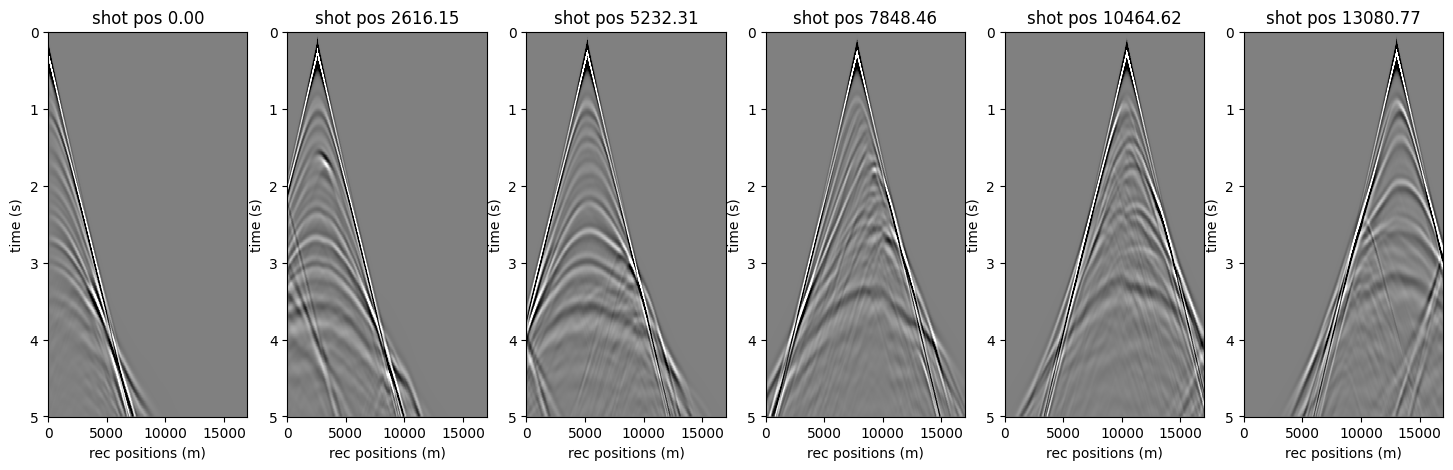

In [6]:
%%time
data_obs = acoustic_2d.forward(true_model)

plotting.plot_data(data_obs,
          d_t,
          src_locations=srcs,
          rec_locations=recs)

## Make starting model

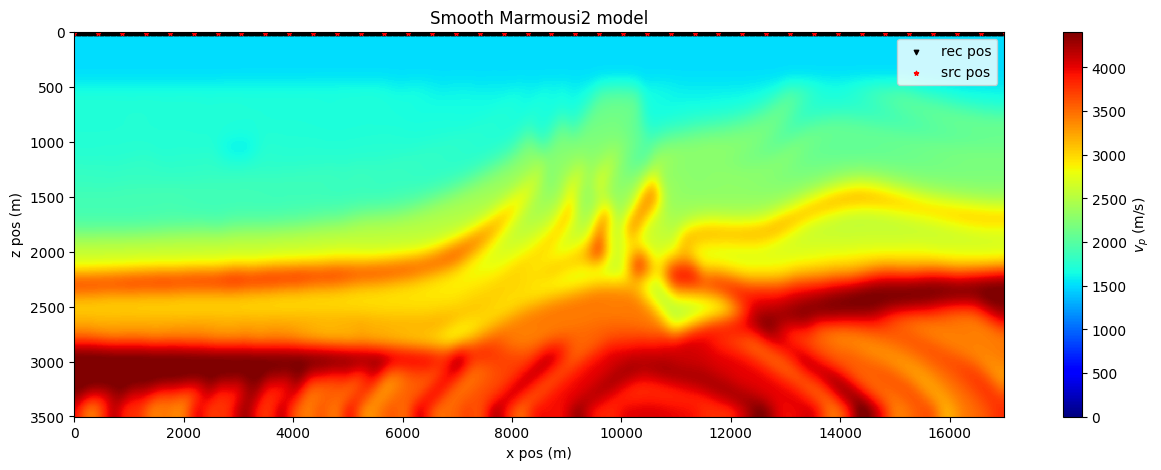

In [7]:
starting_model = ndimage.gaussian_filter(true_model,(20,20))

plotting.plot_model(starting_model,
           title='Smooth Marmousi2 model', 
           cbar=True,
           src_locations=srcs,
           rec_locations=recs)

## FWI 

In [8]:
fwi_prob = inversion.Fwi(acoustic_2d,
                         data_obs,
                         starting_model,
                         num_iter=20,
                         iterations_per_save=5)

In [ ]:
%%time

history = fwi_prob.run()

##########################################################################################
Broyden-Fletcher-Goldfarb-Shanno (BFGS) algorithm 
Restart folder: /tmp/restart_2023-01-12T01-40-46.788443/
##########################################################################################

iter = 00, obj = 8.13570e+04, resnorm = 4.03e+02, gradnorm = 7.37e+00, feval = 1, geval = 1
iter = 01, obj = 4.36251e+04, resnorm = 2.95e+02, gradnorm = 2.37e+00, feval = 4, geval = 2
iter = 02, obj = 3.41258e+04, resnorm = 2.61e+02, gradnorm = 1.91e+00, feval = 7, geval = 3
iter = 03, obj = 2.73146e+04, resnorm = 2.34e+02, gradnorm = 1.61e+00, feval = 10, geval = 4
iter = 04, obj = 2.42473e+04, resnorm = 2.20e+02, gradnorm = 1.09e+00, feval = 13, geval = 5
iter = 05, obj = 2.17132e+04, resnorm = 2.08e+02, gradnorm = 9.29e-01, feval = 16, geval = 6
iter = 06, obj = 2.00604e+04, resnorm = 2.00e+02, gradnorm = 8.61e-01, feval = 19, geval = 7
iter = 07, obj = 1.77758e+04, resnorm = 1.89e+02, gradnorm = 

In [14]:
history.keys()

dict_keys(['inv_mod', 'gradient', 'model', 'residual', 'obj'])

## Plot objective function as a function of iteration

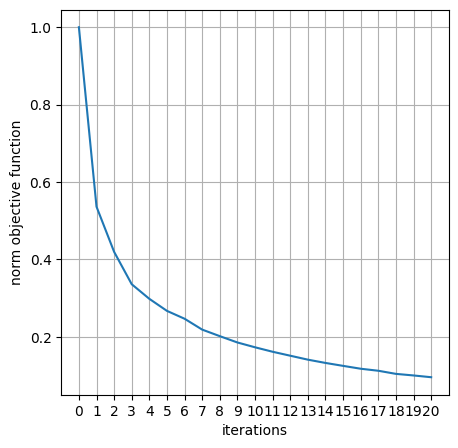

In [15]:
obj_func = history['obj']

fig, ax = plt.subplots(1,figsize=(5,5))
ax.plot(obj_func/obj_func.max())
_ = ax.set_xlabel('iterations')
_ = ax.set_ylabel('norm objective function')
_ = ax.set_xticks(np.arange(len(obj_func)))
ax.grid()

## Plot final model

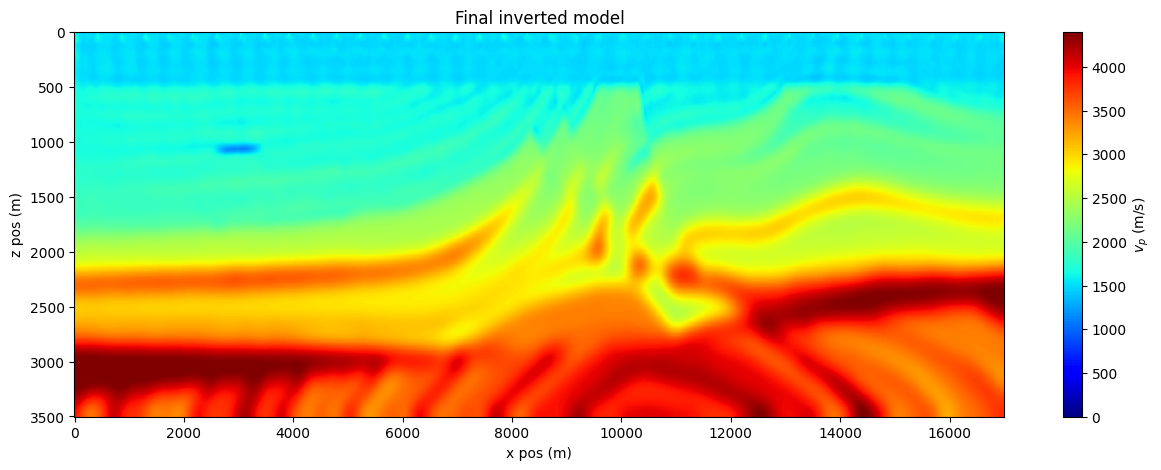

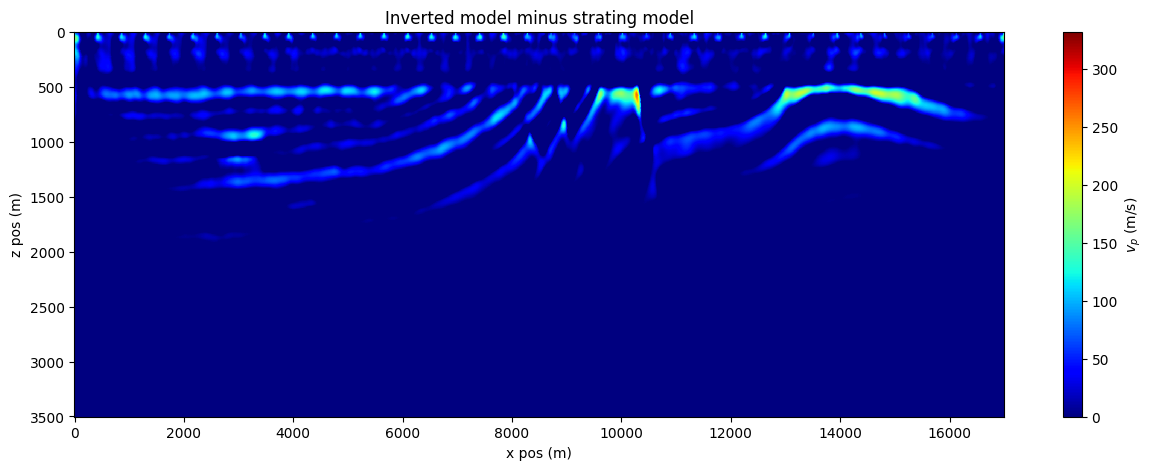

In [16]:
plotting.plot_model(history['inv_mod'],
           title='Final inverted model', 
           cbar=True)

plotting.plot_model(history['inv_mod']-starting_model,
           title='Inverted model minus strating model', 
           cbar=True,
          pclip=100)

## Plot first and last residual

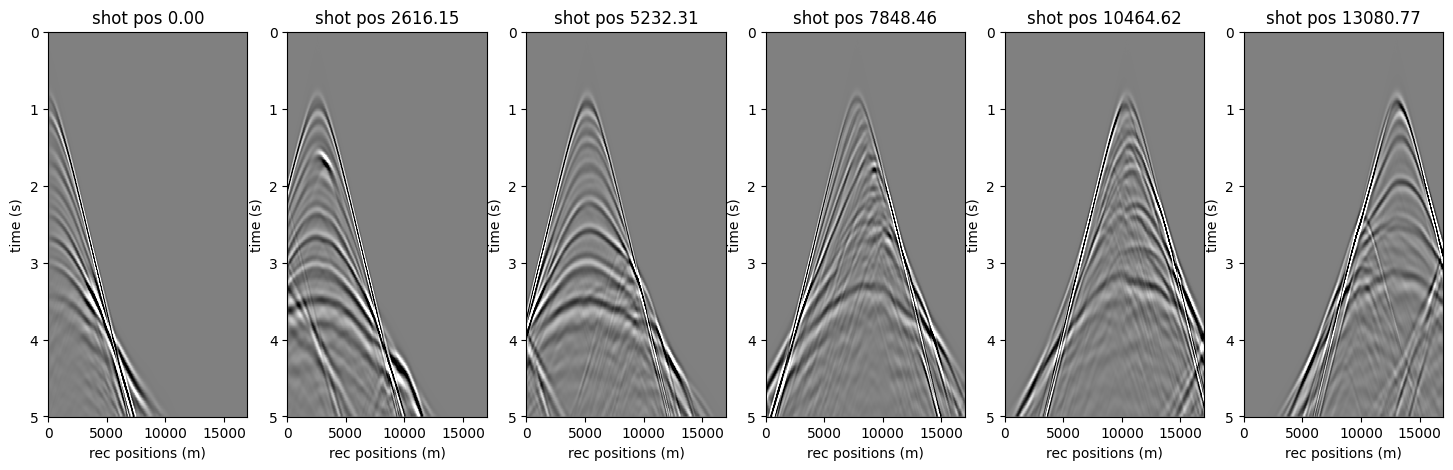

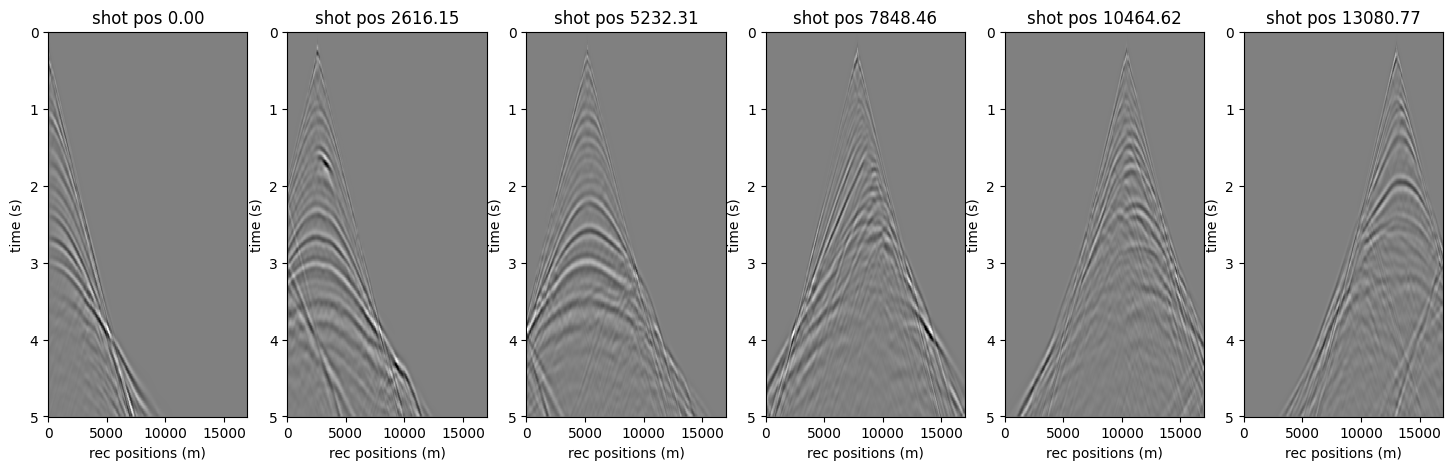

In [17]:
clip = np.percentile(data_obs,99)

plotting.plot_data(history['residual'][0],
          d_t,
          src_locations=srcs,
          rec_locations=recs,
          clip=clip)

plotting.plot_data(history['residual'][-1],
          d_t,
          src_locations=srcs,
          rec_locations=recs,
          clip=clip)